<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import pandas as pd
# cross validation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# model saving
import pickle

import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [163]:
df = pd.read_csv("data/churn_data_encoded.csv")
df.head()

,churn_flag,gender_Female,gender_Male,seniorcitizen_No,seniorcitizen_Yes,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,...,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges
0,0.0,1,0,1,0,0,1,1,0,1,...,0,0,1,0,0,1,0,0.000000,0.115423,0.001275
1,0.0,0,1,1,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0.464789,0.385075,0.215867
2,1.0,0,1,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0.014085,0.354229,0.010310
3,0.0,0,1,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0.619718,0.239303,0.210241
4,1.0,1,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0.014085,0.521891,0.015330


In [ ]:
df.shape

(10326, 47)

In [165]:
x = df.drop('churn_flag', axis = 1)
y = df['churn_flag'].values

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

## Model Training

In [166]:
# Grid Search
def get_best_model(estimator, params_grid = {}):
  model = GridSearchCV(estimator = estimator, param_grid = params_grid, cv = 3, scoring = 'accuracy', n_jobs = - 1)
  model.fit(x_train, y_train)
  print('\n--- Best Parameters-----------------------------')
  print(model.best_params_)
  print('\n--- Best Model---------------------------------')
  best_model = model.best_estimator_
  print(best_model)
  return best_model

In [167]:
# model fit function
def model_fit(model, feature_imp = True, cv = 5):

  clf = model.fit(x_train, y_train)

  # prediction
  y_pred = clf.predict(x_test)

  print('\n--- Train Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
  print('\n--- Validation Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
  print('-----------------------------------------------')

  # reports
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm, classes = class_names, title = 'Confusion Matrix')
  print(' ')

  # feature importance
  if feature_imp:
      feat_imp = pd.Series(clf.feature_importances_,index=x_train.columns)
      feat_imp = feat_imp.nlargest(15).sort_values()
      plt.figure()
      plt.title("Most Important Features")
      feat_imp.plot(kind="barh")
      plt.show()



In [168]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
class_names = ['Success','Failure']


## Random Forests


--- Best Parameters-----------------------------
{'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 150}

--- Best Model---------------------------------
RandomForestClassifier(max_depth=50, n_estimators=150, random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84770 +/- 0.0088
AUC: 0.92023 +/- 0.0056

--- Validation Set -----------------------------
Accuracy: 0.80493 +/- 0.0121
AUC: 0.87634 +/- 0.0139
-----------------------------------------------


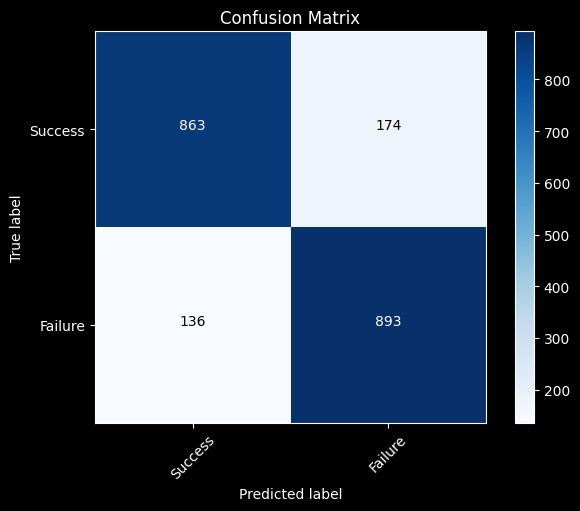

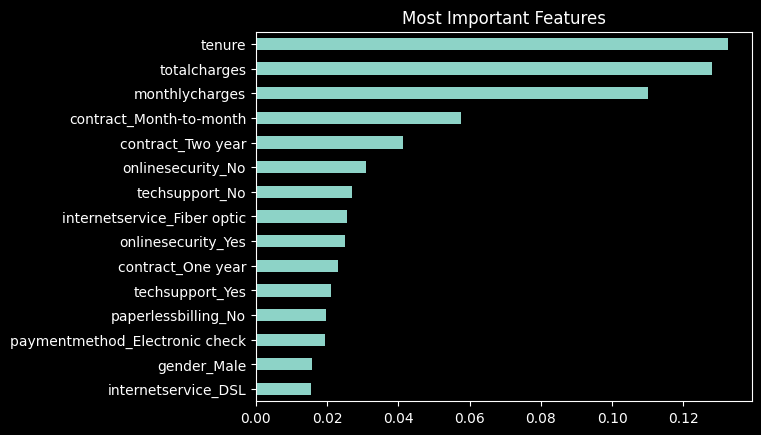

In [169]:
classifier_rf = RandomForestClassifier(random_state = 42)
parameters = {
              'n_estimators': [100, 150, 200],
              'max_depth':[10, 30, 50],
              'max_features': ['sqrt']
              }

clf_rf = get_best_model(classifier_rf, parameters)
model_fit(model = clf_rf, feature_imp = True)

## K-Nearest Neighbors KNN


--- Best Parameters-----------------------------
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

--- Best Model---------------------------------
KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

--- Train Set -----------------------------
Accuracy: 0.80896 +/- 0.0094
AUC: 0.88214 +/- 0.0050

--- Validation Set -----------------------------
Accuracy: 0.76234 +/- 0.0193
AUC: 0.83571 +/- 0.0128
-----------------------------------------------


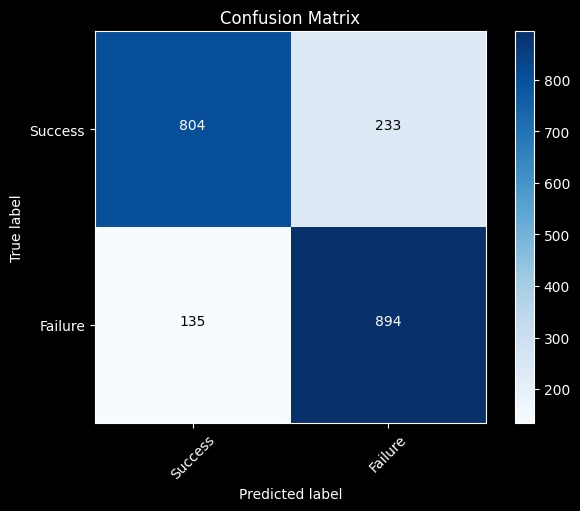

In [170]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [5,6,7],
              'p':[1,2],
              'weights':['uniform', 'distance']}

clf_knn = get_best_model(knn, parameters)
model_fit(model = clf_knn, feature_imp = False)

## Naive Bayes


--- Train Set -----------------------------
Accuracy: 0.76102 +/- 0.0134
AUC: 0.83751 +/- 0.0079

--- Validation Set -----------------------------
Accuracy: 0.75411 +/- 0.0155
AUC: 0.83389 +/- 0.0198
-----------------------------------------------


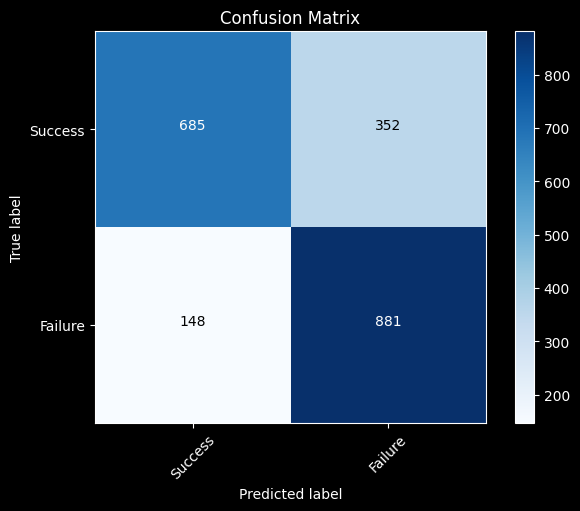

In [171]:
clf_nb = GaussianNB()
model_fit(model = clf_nb, feature_imp = False)

## Logistic Regression


--- Best Parameters-----------------------------
{'penalty': 'l2'}

--- Best Model---------------------------------
LogisticRegression(random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84576 +/- 0.0067
AUC: 0.93210 +/- 0.0036

--- Validation Set -----------------------------
Accuracy: 0.83203 +/- 0.0199
AUC: 0.91717 +/- 0.0137
-----------------------------------------------


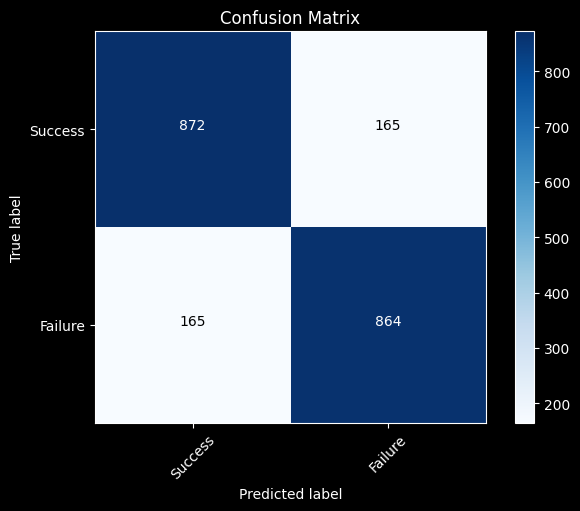

In [172]:
lg = LogisticRegression(random_state=42)
parameters = {
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)


## XGBoost


--- Train Set -----------------------------
Accuracy: 0.84588 +/- 0.0038
AUC: 0.92916 +/- 0.0033

--- Validation Set -----------------------------
Accuracy: 0.80687 +/- 0.0053
AUC: 0.88606 +/- 0.0115
-----------------------------------------------


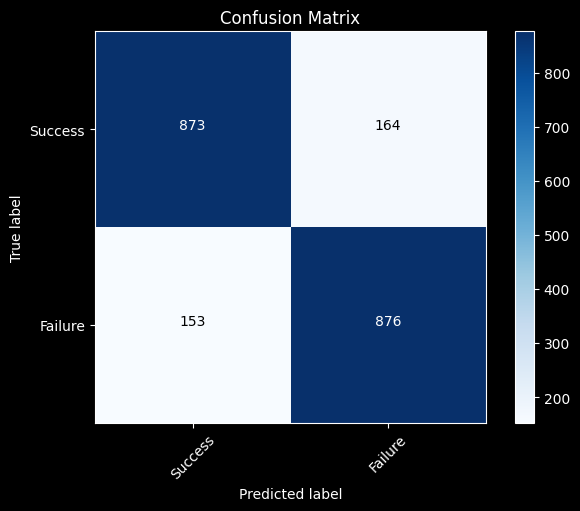

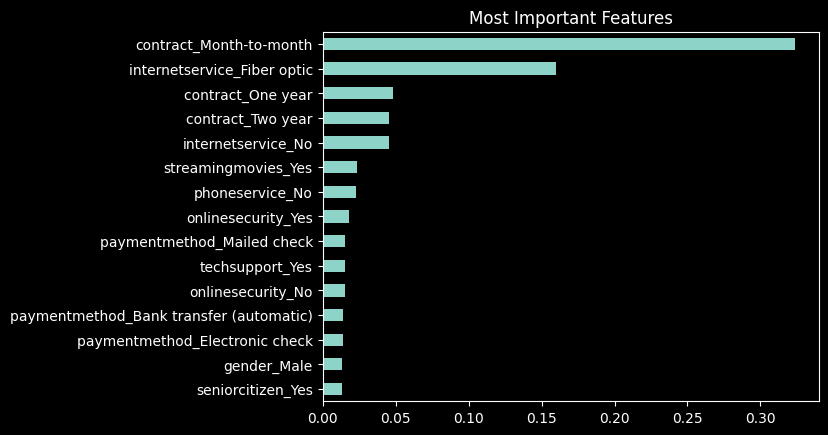

In [173]:
clf_xgb = XGBClassifier(random_state = 42)
model_fit(model = clf_xgb, feature_imp = True)

# Evaluation

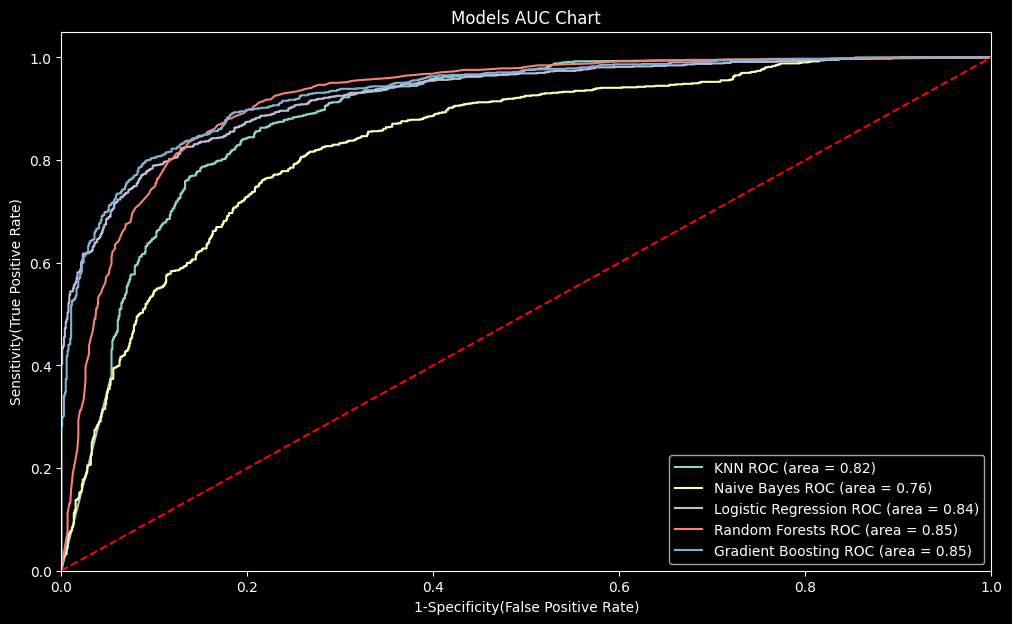

In [174]:
plt.figure(figsize = (12, 7))
models = [
{
    'label': 'KNN',
    'model': clf_knn,
},
{
    'label': 'Naive Bayes',
    'model': clf_nb,
},
{
    'label': 'Logistic Regression',
    'model': clf_lg,
},
{
    'label': 'Random Forests',
    'model': clf_rf,
},
{
    'label': 'Gradient Boosting',
    'model': clf_xgb,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Models AUC Chart')
plt.legend(loc="lower right")
plt.show()   # Display

## K-Fold Cross Validation

In [ ]:
# Compare model performance(KFold)
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_xgb]
index =['KNN', 'Naive Bayes', 'Logistic Regression','Random Forests', 'XG Boost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

Logistic Regression    0.832026
XG Boost               0.806870
Random Forests         0.804928
KNN                    0.762336
Naive Bayes            0.754107
dtype: float64

## Selected Model: Logistic Regression

After careful evaluation of the performance metrics for Random Forests, K-Nearest Neighbors (KNN), Naive Bayes, Logistic Regression, and XGBoost, I have decided to choose the **Logistic Regression** model for the customer churn prediction task. The decision is based on the following reasons, which align with the goal of maximizing predictive performance while ensuring practical deployment and business impact:

1. **Highest Accuracy and Robustness**:
   Logistic Regression achieved the highest K-Fold cross-validation accuracy of **0.832026**, surpassing XGBoost (0.806870), Random Forests (0.804928), KNN (0.762336), and Naive Bayes (0.754107). Its validation set accuracy of **0.83203 ± 0.0199** is also the highest, indicating strong and consistent performance on unseen data. High accuracy is critical for reliable churn predictions, ensuring the company can trust the model’s outputs for retention strategies.

2. **Superior Discrimination (AUC)**:
   The model’s validation AUC of **0.91717 ± 0.0137** is the highest among all models, compared to XGBoost (0.88606), Random Forests (0.87634), KNN, and Naive Bayes. The ROC AUC of **0.84** further supports its strong ability to discriminate between churned and non-churned customers. A high AUC ensures the model effectively identifies at-risk customers, which is essential for targeting retention campaigns.

3. **Balanced False Positives and Negatives**:
   The confusion matrix for Logistic Regression shows **872 true positives (TP)**, **165 false positives (FP)**, **165 false negatives (FN)**, and **864 true negatives (TN)**. Compared to other models:
   - **False Negatives (FN)**: Logistic Regression (165 FN) performs better than Random Forests (136 FN), KNN (135 FN), Naive Bayes (148 FN), and is close to XGBoost (153 FN). Low FN ensures fewer churned customers are missed, maximizing retention opportunities.
   - **False Positives (FP)**: With 165 FP, it outperforms KNN (233 FP) and Naive Bayes (352 FP), and is competitive with XGBoost (164 FP) and Random Forests (174 FP). Low FP prevents wasting resources on non-churners.
   This balance is crucial for optimizing retention campaign costs and effectiveness.

4. **Interpretability and Scalability**:
   Logistic Regression offers inherent interpretability through its coefficients, which directly indicate the impact of each feature on churn probability (as saved in `feat_imp.csv`). This transparency enables the company to understand key churn drivers (e.g., contract length, payment issues) and design targeted interventions. Unlike ensemble methods like XGBoost or Random Forests, Logistic Regression is computationally lightweight and easier to deploy in production, making it scalable for real-time predictions in CRM systems.

5. **Practical Business Alignment**:
   The model’s high accuracy and AUC, combined with its balanced error rates, ensure it delivers actionable predictions for customer retention. By minimizing missed churners (FN) and unnecessary interventions (FP), Logistic Regression maximizes ROI for retention campaigns. Its feature importance insights (from coefficients) further support strategic decisions, such as product or pricing improvements, enhancing long-term customer satisfaction.

### Supporting Metrics
The following metrics informed the decision:

| Model              | K-Fold Accuracy | Validation Accuracy | Validation AUC | ROC AUC | False Negatives | False Positives |
|--------------------|-----------------|---------------------|----------------|---------|-----------------|-----------------|
| Logistic Regression | **0.832026**    | **0.83203 ± 0.0199** | **0.91717 ± 0.0137** | 0.84    | 165             | 165             |
| XGBoost            | 0.806870        | 0.80687 ± 0.0053    | 0.88606 ± 0.0115 | **0.85** | 153             | 164             |
| Random Forests     | 0.804928        | 0.80493 ± 0.0121    | 0.87634 ± 0.0139 | **0.85** | 136             | 174             |
| KNN                | 0.762336        | -                   | -              | 0.82    | 135             | 233             |
| Naive Bayes        | 0.754107        | -                   | -              | 0.76    | 148             | 352             |


In [176]:
filename = 'model.sav'

#pickle.dump(clf_xgb, open(filename, 'wb'))
pickle.dump(clf_lg, open(filename, 'wb'))

# Analysis

### Feature Importances

- **Positive coefficients**: Increase the likelihood of churn as the feature value increases.

- **Negative coefficients**: Decrease the likelihood of churn as the feature value increases.

- **Larger absolute coefficients**: Indicate stronger influence on churn prediction.

In [177]:
# Extract feature importances (coefficients)
feature_names = x.columns
coefficients = clf_lg.coef_[0]  # For binary classification, coef_ is 1D
importances = np.abs(coefficients)  # Absolute values for importance

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': importances
})
top_20 = importance_df.sort_values(by='Importance', ascending=False).head(20)
top_20 = top_20.sort_values(by='Importance', ascending=True)  


In [178]:
# Create the Plotly bar chart
fig = px.bar(top_20, 
             x='Importance', 
             y='Feature', 
             orientation='h',
             title='Feature Importances (Logistic Regression)',
             color='Importance', 
             color_continuous_scale='viridis',
             labels={'Importance': 'Top features by importance', 'Feature': 'Feature'})
fig.update_layout(showlegend=True, 
                  template='plotly_dark',
                  width=1000,
                  height=600)

In [179]:
top_20.to_csv('data/top_20.csv', index=False)

### Features most Relevant for causing churn

In [180]:
#top_20 = importance_df.sort_values(by=['Coefficient'], ascending=[False]).head(10)
top_20 = importance_df.sort_values(by='Importance', ascending=True).head(10)
top_20['abs_coef'] = abs(top_20['Coefficient'])

# Create the Plotly bar chart
fig = px.bar(top_20, 
             x='Importance', 
             y='Feature', 
             orientation='h',
             title='Feature Importances (Logistic Regression)',
             color='Importance', 
             color_continuous_scale='viridis',
             labels={'Importance': 'Top features by importance', 'Feature': 'Feature'})
fig.update_layout(showlegend=True, 
                  template='plotly_dark',
                  width=1000,
                  height=600)

<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import pandas as pd
# cross validation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# model saving
import pickle

import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [182]:
df = pd.read_csv("data/churn_data_encoded.csv")
df.head()

,churn_flag,gender_Female,gender_Male,seniorcitizen_No,seniorcitizen_Yes,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,...,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges
0,0.0,1,0,1,0,0,1,1,0,1,...,0,0,1,0,0,1,0,0.000000,0.115423,0.001275
1,0.0,0,1,1,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0.464789,0.385075,0.215867
2,1.0,0,1,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0.014085,0.354229,0.010310
3,0.0,0,1,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0.619718,0.239303,0.210241
4,1.0,1,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0.014085,0.521891,0.015330


In [183]:
df.shape

(10326, 47)

In [184]:
x = df.drop('churn_flag', axis = 1)
y = df['churn_flag'].values

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

## Model Training

In [185]:
# Grid Search
def get_best_model(estimator, params_grid = {}):
  model = GridSearchCV(estimator = estimator, param_grid = params_grid, cv = 3, scoring = 'accuracy', n_jobs = - 1)
  model.fit(x_train, y_train)
  print('\n--- Best Parameters-----------------------------')
  print(model.best_params_)
  print('\n--- Best Model---------------------------------')
  best_model = model.best_estimator_
  print(best_model)
  return best_model

In [186]:
# model fit function
def model_fit(model, feature_imp = True, cv = 5):

  clf = model.fit(x_train, y_train)

  # prediction
  y_pred = clf.predict(x_test)

  print('\n--- Train Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
  print('\n--- Validation Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
  print('-----------------------------------------------')

  # reports
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm, classes = class_names, title = 'Confusion Matrix')
  print(' ')

  # feature importance
  if feature_imp:
      feat_imp = pd.Series(clf.feature_importances_,index=x_train.columns)
      feat_imp = feat_imp.nlargest(15).sort_values()
      plt.figure()
      plt.title("Most Important Features")
      feat_imp.plot(kind="barh")
      plt.show()



In [187]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
class_names = ['Success','Failure']


## Random Forests


--- Best Parameters-----------------------------
{'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 150}

--- Best Model---------------------------------
RandomForestClassifier(max_depth=50, n_estimators=150, random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84770 +/- 0.0088
AUC: 0.92023 +/- 0.0056

--- Validation Set -----------------------------
Accuracy: 0.80493 +/- 0.0121
AUC: 0.87634 +/- 0.0139
-----------------------------------------------


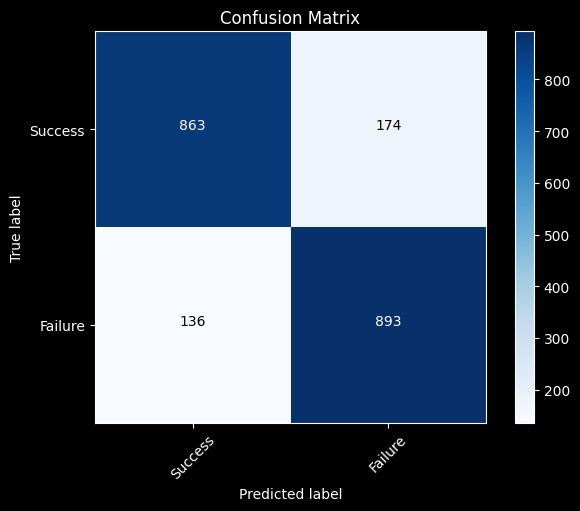

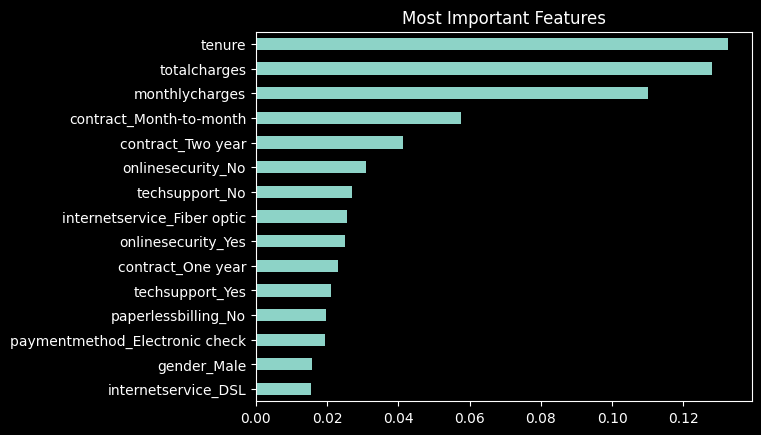

In [188]:
classifier_rf = RandomForestClassifier(random_state = 42)
parameters = {
              'n_estimators': [100, 150, 200],
              'max_depth':[10, 30, 50],
              'max_features': ['sqrt']
              }

clf_rf = get_best_model(classifier_rf, parameters)
model_fit(model = clf_rf, feature_imp = True)

## K-Nearest Neighbors KNN


--- Best Parameters-----------------------------
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

--- Best Model---------------------------------
KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

--- Train Set -----------------------------
Accuracy: 0.80896 +/- 0.0094
AUC: 0.88214 +/- 0.0050

--- Validation Set -----------------------------
Accuracy: 0.76234 +/- 0.0193
AUC: 0.83571 +/- 0.0128
-----------------------------------------------


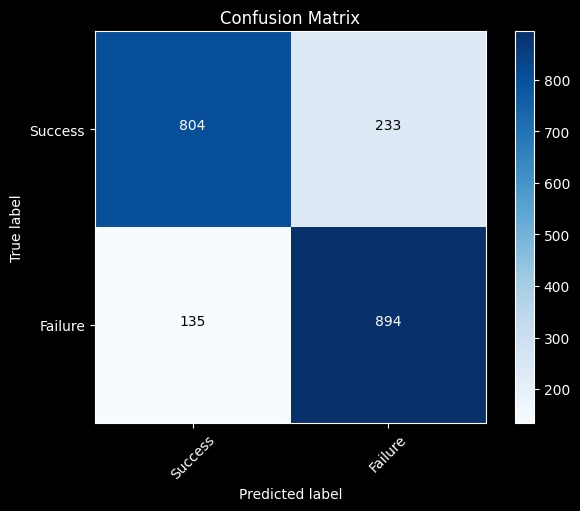

In [189]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [5,6,7],
              'p':[1,2],
              'weights':['uniform', 'distance']}

clf_knn = get_best_model(knn, parameters)
model_fit(model = clf_knn, feature_imp = False)

## Naive Bayes


--- Train Set -----------------------------
Accuracy: 0.76102 +/- 0.0134
AUC: 0.83751 +/- 0.0079

--- Validation Set -----------------------------
Accuracy: 0.75411 +/- 0.0155
AUC: 0.83389 +/- 0.0198
-----------------------------------------------


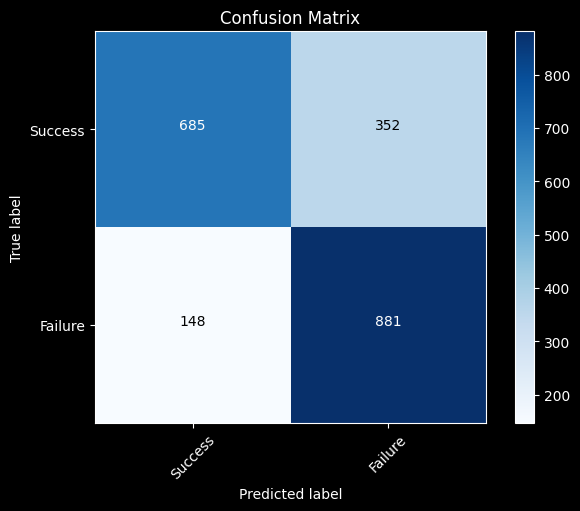

In [190]:
clf_nb = GaussianNB()
model_fit(model = clf_nb, feature_imp = False)

## Logistic Regression


--- Best Parameters-----------------------------
{'penalty': 'l2'}

--- Best Model---------------------------------
LogisticRegression(random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84576 +/- 0.0067
AUC: 0.93210 +/- 0.0036

--- Validation Set -----------------------------
Accuracy: 0.83203 +/- 0.0199
AUC: 0.91717 +/- 0.0137
-----------------------------------------------


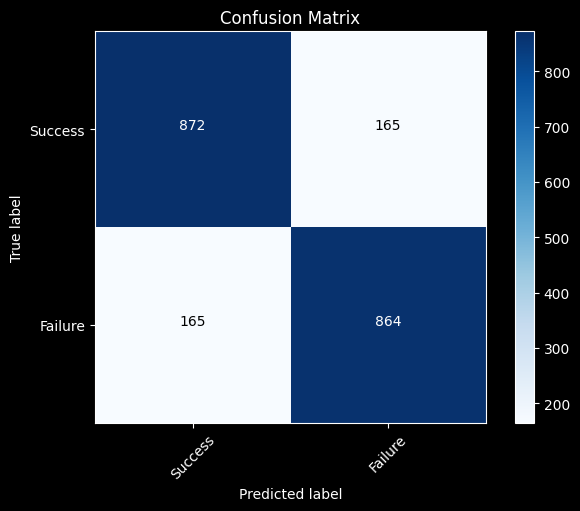

In [191]:
lg = LogisticRegression(random_state=42)
parameters = {
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)


## XGBoost


--- Train Set -----------------------------
Accuracy: 0.84588 +/- 0.0038
AUC: 0.92916 +/- 0.0033

--- Validation Set -----------------------------
Accuracy: 0.80687 +/- 0.0053
AUC: 0.88606 +/- 0.0115
-----------------------------------------------


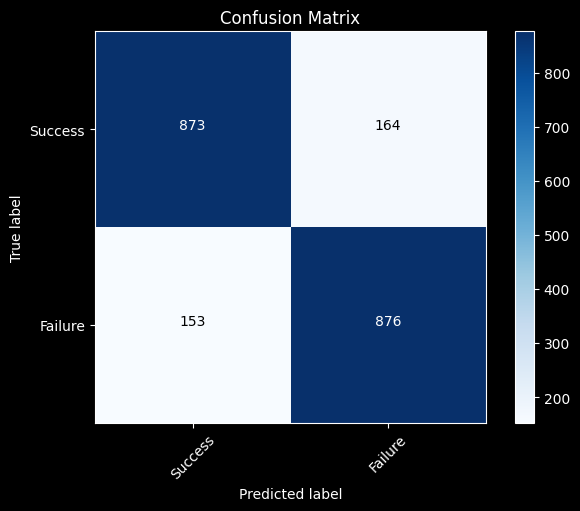

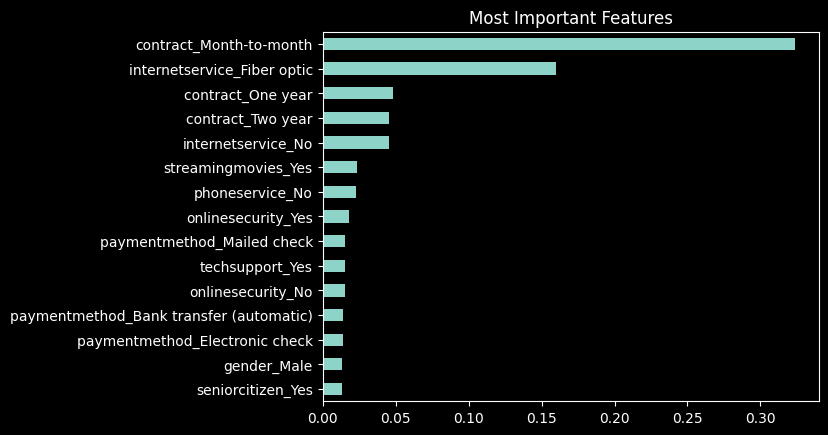

In [192]:
clf_xgb = XGBClassifier(random_state = 42)
model_fit(model = clf_xgb, feature_imp = True)

# Evaluation

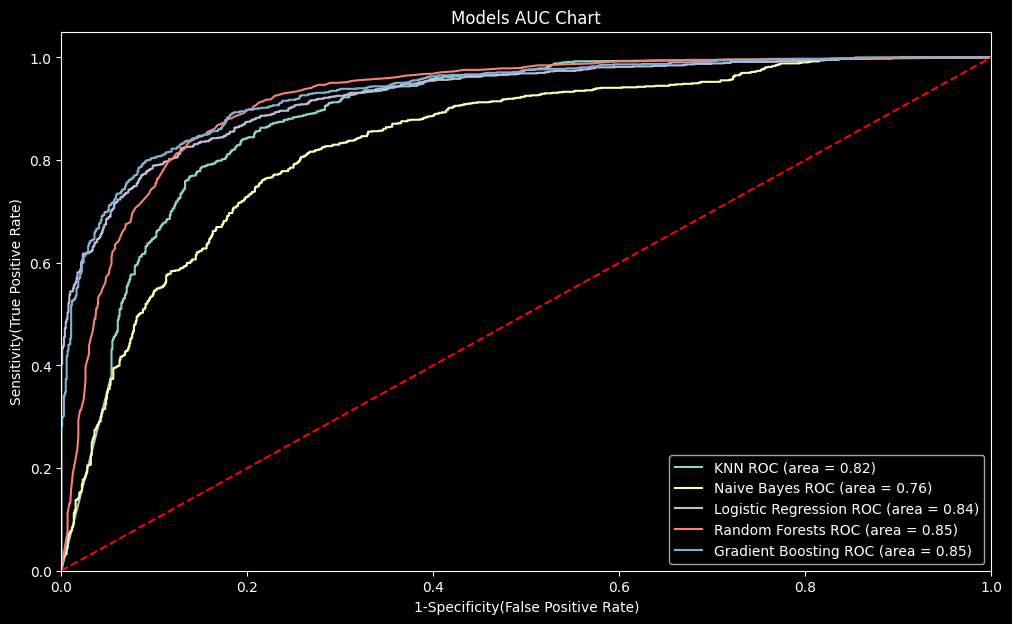

In [193]:
plt.figure(figsize = (12, 7))
models = [
{
    'label': 'KNN',
    'model': clf_knn,
},
{
    'label': 'Naive Bayes',
    'model': clf_nb,
},
{
    'label': 'Logistic Regression',
    'model': clf_lg,
},
{
    'label': 'Random Forests',
    'model': clf_rf,
},
{
    'label': 'Gradient Boosting',
    'model': clf_xgb,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Models AUC Chart')
plt.legend(loc="lower right")
plt.show()   # Display

## K-Fold Cross Validation

In [194]:
# Compare model performance(KFold)
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_xgb]
index =['KNN', 'Naive Bayes', 'Logistic Regression','Random Forests', 'XG Boost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

Logistic Regression    0.832026
XG Boost               0.806870
Random Forests         0.804928
KNN                    0.762336
Naive Bayes            0.754107
dtype: float64

## Selected Model: Logistic Regression

After careful evaluation of the performance metrics for Random Forests, K-Nearest Neighbors (KNN), Naive Bayes, Logistic Regression, and XGBoost, I have decided to choose the **Logistic Regression** model for the customer churn prediction task. The decision is based on the following reasons, which align with the goal of maximizing predictive performance while ensuring practical deployment and business impact:

1. **Highest Accuracy and Robustness**:
   Logistic Regression achieved the highest K-Fold cross-validation accuracy of **0.832026**, surpassing XGBoost (0.806870), Random Forests (0.804928), KNN (0.762336), and Naive Bayes (0.754107). Its validation set accuracy of **0.83203 ± 0.0199** is also the highest, indicating strong and consistent performance on unseen data. High accuracy is critical for reliable churn predictions, ensuring the company can trust the model’s outputs for retention strategies.

2. **Superior Discrimination (AUC)**:
   The model’s validation AUC of **0.91717 ± 0.0137** is the highest among all models, compared to XGBoost (0.88606), Random Forests (0.87634), KNN, and Naive Bayes. The ROC AUC of **0.84** further supports its strong ability to discriminate between churned and non-churned customers. A high AUC ensures the model effectively identifies at-risk customers, which is essential for targeting retention campaigns.

3. **Balanced False Positives and Negatives**:
   The confusion matrix for Logistic Regression shows **872 true positives (TP)**, **165 false positives (FP)**, **165 false negatives (FN)**, and **864 true negatives (TN)**. Compared to other models:
   - **False Negatives (FN)**: Logistic Regression (165 FN) performs better than Random Forests (136 FN), KNN (135 FN), Naive Bayes (148 FN), and is close to XGBoost (153 FN). Low FN ensures fewer churned customers are missed, maximizing retention opportunities.
   - **False Positives (FP)**: With 165 FP, it outperforms KNN (233 FP) and Naive Bayes (352 FP), and is competitive with XGBoost (164 FP) and Random Forests (174 FP). Low FP prevents wasting resources on non-churners.
   This balance is crucial for optimizing retention campaign costs and effectiveness.

4. **Interpretability and Scalability**:
   Logistic Regression offers inherent interpretability through its coefficients, which directly indicate the impact of each feature on churn probability (as saved in `feat_imp.csv`). This transparency enables the company to understand key churn drivers (e.g., contract length, payment issues) and design targeted interventions. Unlike ensemble methods like XGBoost or Random Forests, Logistic Regression is computationally lightweight and easier to deploy in production, making it scalable for real-time predictions in CRM systems.

5. **Practical Business Alignment**:
   The model’s high accuracy and AUC, combined with its balanced error rates, ensure it delivers actionable predictions for customer retention. By minimizing missed churners (FN) and unnecessary interventions (FP), Logistic Regression maximizes ROI for retention campaigns. Its feature importance insights (from coefficients) further support strategic decisions, such as product or pricing improvements, enhancing long-term customer satisfaction.

### Supporting Metrics
The following metrics informed the decision:

| Model              | K-Fold Accuracy | Validation Accuracy | Validation AUC | ROC AUC | False Negatives | False Positives |
|--------------------|-----------------|---------------------|----------------|---------|-----------------|-----------------|
| Logistic Regression | **0.832026**    | **0.83203 ± 0.0199** | **0.91717 ± 0.0137** | 0.84    | 165             | 165             |
| XGBoost            | 0.806870        | 0.80687 ± 0.0053    | 0.88606 ± 0.0115 | **0.85** | 153             | 164             |
| Random Forests     | 0.804928        | 0.80493 ± 0.0121    | 0.87634 ± 0.0139 | **0.85** | 136             | 174             |
| KNN                | 0.762336        | -                   | -              | 0.82    | 135             | 233             |
| Naive Bayes        | 0.754107        | -                   | -              | 0.76    | 148             | 352             |


In [195]:
filename = 'model.sav'

#pickle.dump(clf_xgb, open(filename, 'wb'))
pickle.dump(clf_lg, open(filename, 'wb'))

# Analysis

### Feature Importances
- 1 for churn and 0 for not churn.
- **Positive coefficients**: Increase the likelihood of churn as the feature value increases.

- **Negative coefficients**: Decrease the likelihood of churn as the feature value increases.

- **Larger absolute coefficients**: Indicate stronger influence on churn prediction.

In [196]:
def plot_importances(df, feature_col='Feature', importance_col='Importance', invert_yaxes=False):
    # Create the Plotly bar chart
    fig = px.bar(df, 
                x= importance_col, 
                y=feature_col, 
                orientation='h',
                title='Feature Importances (Logistic Regression)',
                color=importance_col, 
                color_continuous_scale='viridis',
                labels={'Importance': 'Top features by importance', 'Feature': 'Feature'})
    fig.update_layout(showlegend=True, 
                    template='plotly_dark',
                    width=1000,
                    height=600)
    if invert_yaxes:
        fig.update_yaxes(autorange='reversed')
    fig.show()

In [197]:
top_20.to_csv('data/top_20.csv', index=False)

### Feature Importance by Odd Ratio

| Odds Ratio | Interpretation                                     |
|------------|-----------------------------------------------------|
| = 1        | No effect: the feature does not change the odds.   |
| > 1        | Increases the odds of the positive class.          |
| < 1        | Decreases the odds of the positive class.          |


<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
# Extract feature importances (coefficients)
feature_names = x.columns
coefficients = clf_lg.coef_[0]  # For binary classification, coef_ is 1D
importances = np.abs(coefficients)  # Absolute values for importance
odd_ratios = np.exp(coefficients)

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': importances,
    'Odd Ratio': odd_ratios
})
top_20 = importance_df.sort_values(by='Coefficient', ascending=False).head(20)


In [200]:
plot_importances(top_20, 'Feature', 'Odd Ratio', invert_yaxes=True)

### Permutation importance

In [216]:
# Permutation Importance
perm_importance = permutation_importance(model, x_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values('Importance Mean', ascending=False).head(20)

In [217]:
plot_importances(perm_importance_df, 'Feature', 'Importance Mean', invert_yaxes=True)

In [219]:
perm_importance_df.to_csv('data/feat_imp.csv', index=False)